# Harmonische Analyse

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
# use to scale figure size
plt.rcParams['figure.dpi'] = 120

## Inhalt

1. [Einleitung](#einleitung)
2. [Fourier-Analyse](#fourier)
    1. [Mathematische Grundlagen](#fourier-mat)
    2. [CFT/DFT](#fourier-dft-cft)
    3. [Beispiele](#fourier-bsp)
    4. [Gridding](#fourier-grid)
    5. [FFT](#fourier-fft)
3. [Lomb-Scargle Periodogramme](#period)
    1. [Mathematische Grundlagen](#period-mat)
    2. [Beispiele](#period-bsp)
4. [Fourier vs. Lomb-Scargle](#vergl)
5. [Ausblick und weitere Literatur](#ausblick)

## Einleitung <a name="einleitung"></a>

Einige Probleme, die bisher in der SMD behandelt wurden, können neben den bereits erwähnten Methoden auch mittels Methoden der harmonischen Analyse behandelt werden. Diese Methoden eignen sich besonders für sogenannte Zeitreihen, also alle Daten, die zusätzlich zu ihren sonstigen Attributen eine zeitliche Dimension besitzen, und zielen darauf ab Informationen durch die Zerlegung der Signale in harmonische Anteile (Sinus- und Cosinus-Funktionen) verschiedener Frequenzen zu gewinnen. 

Ein Beispiel wäre die Suche nach einem Radiosignal in einem Rauschuntergrund. Intrinsisch geeignet sind diese Methoden auch für periodische Probleme, zum Beispiel Messungen von Exoplaneten die ein Zentralgestirn umkreisen. Im Folgenden wird auf zwei wichtigste Methoden eingegangen: Die __Fourier-Analyse__ und die __Lomb-Scargle Periodogramme__.

## Fourier-Analyse <a name="fourier"></a>

### Mathematische Grundlagen <a name="fourier-mat"></a>

Die Fourier-Reihe und die Fourier-Entwicklung wurden von _Jean Baptiste Joseph Fourier_ eingeführt.
Durch die nach ihm benannte Fourier-Reihe

$$
\begin{equation}
    \frac{c_0}{2} + \sum_{k = 1}^{\infty} (c_m \cos(mt) + s_m \sin(mt))
\end{equation}
$$

kann fast jede periodische Funktion mit der Periondenlänge $T = 2\pi$ nachgebildet werden. Die Koeffizienten $c_m$ und $s_m$ sind hierbei an die nachzubilden Funktion anzupassen und bestimmen sich durch

$$
\begin{aligned}
    c_m \,&=\,\frac{1}{\pi}\int_{-\pi}^{\pi}f(t)\,\cos(mx)\,dt \qquad m \in \mathbb{N_0}\\
    s_m \,&=\,\frac{1}{\pi}\int_{-\pi}^{\pi}f(t)\,\sin(mx)\,dt \qquad m \in \mathbb{N_0}.\\
\end{aligned}
$$

Durch Nutzung komplexwertiger Koeffizienten lässt sich die Fourierzerlegung handlicher formulieren

$$
\begin{equation}
f_{\rm IF}(t) \,=\, \sum_{m = -\infty}^{\infty}a_m \,e^{\mathrm{i} mt}
\end{equation}
$$

die Koefizienten sind dabei durch

$$
\begin{equation}
a_m \,=\, \frac{1}{2\pi}\int_{-\pi}^{\pi}f(t)e^{-\mathrm{i} mt}\,dt\qquad \forall m\in\mathbb{Z}
\end{equation}
$$

gegeben. Eine Ersetzung $t \rightarrow \frac{2\pi}{T} t$ erweitert die Fourierzerlegung auf Funktionen beliebiger Periodizität, die Integrale der Koefizienten werden in diesem Fall auf $[-\frac{T}{2}, \, \frac{T}{2}]$ ausgewertet. Die in den Ausdrücken entstehenden Terme $\frac{2\pi m}{T}$ können als Kreisfrequenzen $\omega_m$ identifiziert werden.
Durch die Fourierzerlegung konnten historisch bisher nicht lösbare Differentialgleichungen gelöst werden und sie gab den Anstoß für die Untersuchung der Konvergenz unendlicher Reihen.

Im folgenden führen wir eine Fourier Zerlegung am Beispiel eines Rechteck Signals durch. Zuerst werden die Koeffizienten in `fs_coeffs` definiert, `fourier_coefficients` bestimmt alle gewünschten Koeffizienten von $-m$ bis $m$ und die Funktion `eval_fourier` bildet die eigentliche Fourier-Summe. Nach der Definition der Rechteck Funktion kann die Zerlegung durchgeführt und geplottet werden.

In [4]:
from functools import partial
from scipy.integrate import quad
# Define some functions to perfom a fourier decomposition

def fs_coeff(func, m, T):
    '''Calculate the mth fourier coeffiecient for func that has period T'''
    def integrand(t):
        return func(t) * np.exp(-1j * m * 2 * np.pi * t / T)

    def real(t):
        return np.real(integrand(t))
    
    def imaginary(t):
        return np.imag(integrand(t))
    
    real_int, _ = quad(real, -T/2, T/2)
    imag_int, _ = quad(imaginary, -T/2, T/2)
    
    return (real_int + 1j * imag_int) / T


def fourier_coefficients(func, max_m, T):
    '''Calculate -max_m ... max_m fourier coefficients'''
    return np.array([fs_coeff(func, m, T) for m in range(-max_m, max_m + 1)]) 


def eval_fourier(t, coefficients, T):
    '''Evaluate the fourier transformation given by coeffiecents at position t'''
    def fourier(am, m):
        return am * np.exp(2.0j * np.pi * m * t / T) 
    
    
    max_m = len(coefficients) // 2
    result = np.sum([fourier(am, m) for m, am in enumerate(coefficients, start=-max_m)], axis=0)
    
    return np.real_if_close(result)

def square_wave(x, T=2*np.pi):
    '''Define a square wave function'''
    return np.where(x % T > (0.5 * T), 0, 1)

<IPython.core.display.Javascript object>


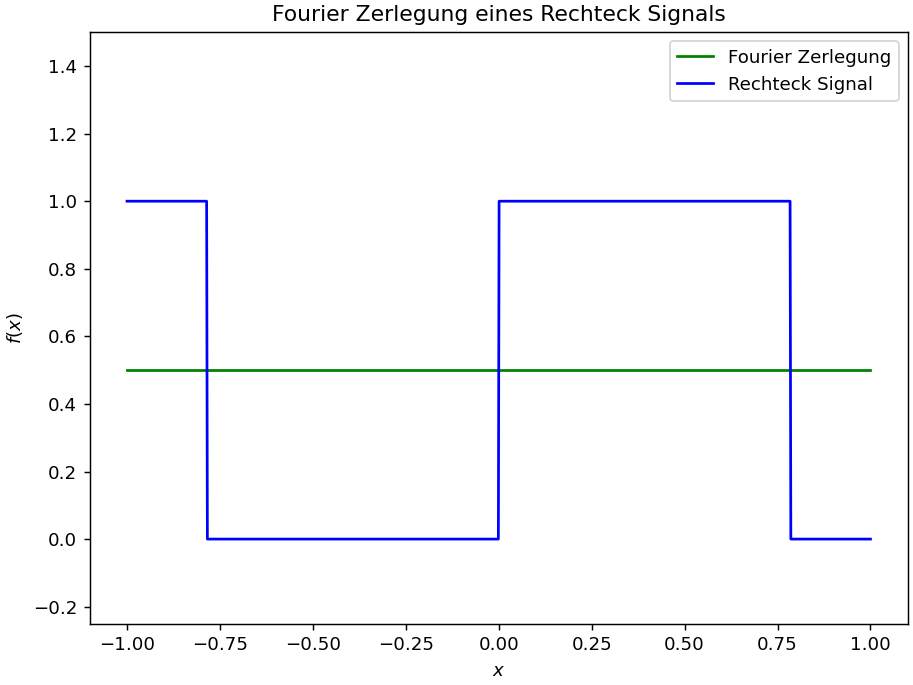

interactive(children=(IntSlider(value=0, description='m', max=20, step=2), FloatSlider(value=1.570796326794896…

<function __main__.plot_fourier(m=0, T=1.5707963267948966)>

In [5]:
from ipywidgets import interact
# Set domain and compute square wave
N = 1000
x = np.linspace(-1.0, 1.0, N)
T = np.pi / 2
f = partial(square_wave, T=T)
coeffs = fourier_coefficients(f, 0, T)


# Compute the FS up to order m

fig, ax = plt.subplots(constrained_layout=True)
line, = ax.plot(x, eval_fourier(x, coeffs, T), 'g', label=r'Fourier Zerlegung')
truth, = ax.plot(x, f(x), 'b', label=r'Rechteck Signal')
ax.set_title(r"Fourier Zerlegung eines Rechteck Signals")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.legend()
ax.set_ylim(-0.25, 1.5)

def plot_fourier(m=0, T=T):
    f = partial(square_wave, T=T)
    coeffs = fourier_coefficients(f, m, T)
    truth.set_ydata(f(x))
    y = eval_fourier(x, coeffs, T)
    line.set_ydata(y)

interact(plot_fourier, m=(0, 20, 2), T=(np.pi/8, 2 * np.pi, 0.05))

### CFT/DFT <a name="fourier-dft-cft"></a>

###### Kontinuierliche Fouriertransformation
Aus der oben eingeführten Formulierung der Fourier-Reihe folgt im Grenzfall unendlicher Periodenlängen $T$ das Fourierintegral 

$$
\begin{equation}
    f(t) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \tilde{f}(\omega) \exp{(\mathrm{i} \omega t)} \mathrm{d}       \omega,
\end{equation}
$$

aus den Fourierkoefizienten lässt sich in diesem Fall die Fouriertransformierte zu $f(t)$ 

$$
\begin{equation}
    \tilde{f}(\omega) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} f(t) \exp{-(\mathrm{i} \omega t)} \mathrm{d}t,
\end{equation}
$$

gewinnen. Dies ist die sogenannte *kontinuierliche Fouriertransformation (CDF)*. 

###### Diskrete Fouriertransformation
In der Realität ist das Messen einer kontinuierlichen Funktion unmöglich, Informationen liegen nur an $N$ diskreten Messzeitpunkten $t_k$ vor, die hier notwendigerweise in gleichförmigem Abstand $\rm \Delta$ liegen. Es gilt entsprechend $t_k = k \rm \Delta$. Trotz dieser diskreten Messung besteht häufig Interesse daran Zugang zu den Informationen im Frequenzraum zu erhalten, es kommt somit zu einer Diskretisierung obriger Integrale. Dabei ist zu beachten, dass bei diskreter Abtastung des zu messenden Signales die messbaren Frequenzen begrenzt sind. Dies ist die zentrale Aussage des __Nyquist-Shannon-Abtasttheorems__, die messbaren Frequenzen sind auf $[-\omega_c, \, + \omega_c]$ mit $\omega_c = \frac{\pi}{\rm \Delta}$ beschränkt, dazwischen liegen gleichverteilt die $N+1$ messbaren Frequenzen

$$
\begin{equation}
    \omega_n = 2\pi \frac{n}{N \rm \Delta} \text{ mit } n = -\frac{N}{2}\, \ldots \, + \frac{N}{2}.
\end{equation}
$$

Entsprechend lässt sich aber auch die Fouriertransformierte nur für die diskreten Frequenzen $\omega_n$ berechnen, es gilt 

$$
\begin{equation}
    \tilde{f}_{\text{diskret}}(\omega_{n}) = \sum_{k=0}^{N-1} f_{\text{diskret}}(t_k) \exp{\left(2\pi\mathrm{i} \frac{kn}{N}\right)}
\end{equation}
$$

und 

$$
\begin{equation}
    f_{\text{diskret}}(t_k) = \frac{1}{N} \sum_{n=0}^{N-1} \tilde{f}_{\text{diskret}}(\omega_{n}) \exp{\left(-2\pi\mathrm{i} \frac{kn}{N}\right)}.
\end{equation}
$$

Dies ist die *diskrete Fouriertransformation (DFT)*.

### Beispiele <a name="fourier-bsp"></a>

##### Zuerst ein einfaches Beispiel: Sinusoidale Funktionen

Wir betrachten 4 eng verwandte Funktionen
$$
\begin{aligned}
f(x) &= 2 \cos{(x)} \\
g(x) &= 2 \cos{(x + 0.5 \pi)} \\
h(x) &= \cos{(x)} \\
i(x) &= 2 \cos{(x)} + 3.\\
\end{aligned}
$$

Zum erzeugen der Fouriertransformationen nutzen wir
```python
scipy.fft.fft,
```
die zugehörigen Frequenzen berechnet 
```python
scipy.fft.fftfreq,
```
die Rücktranformation (an dieser Stelle nicht gezeigt) wäre durch
```python
scipy.fft.ifft,
```
möglich.
Zu beachten ist, dass die Fouriertransformation auch reelle Eingaben auf komplexe Werte abbildet, wir haben also Zugriff auf Amplituden- und Phaseninformationen.

Für diesen Testfall sind die 4 Funktionen je äquidistant auf einem Grid gesampled.

In [6]:
from scipy.fft import fft, fftfreq
# Constants
spacing = 0.1
w = 1.0
phi = np.pi/2
A = 2

# x-space
x = np.arange(0, 10*np.pi, spacing)

# y-values
y_0 = A*np.cos(w*x)
y_0_phase = A*np.cos(w*x+phi)
y_0_amplitude = 0.5*A*np.cos(w*x)
y_0_offset = 3+y_0

# fft transform
A_signal_fft_0 = fft(y_0)
A_signal_fft_0_phase = fft(y_0_phase)
A_signal_fft_0_amplitude = fft(y_0_amplitude)
A_signal_fft_0_offset = fft(y_0_offset)
frequencies = fftfreq(np.size(x), spacing)

###### Betrachten wir zuerst die Amplituden

In [7]:
# Plotting functions for amplitude and phase

def plot_amplitude(x, y, style, label, xlim=(-5, 5), ylim=(-25, 1000)):
    plt.stem(x, y, style, label=label)
    plt.xlabel(r"Kreisfrequenz")
    plt.ylabel("Amplitude / a.u.")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(loc='upper right')
    
def plot_phase(x, y, style, label, xlim=(-5, 5), ylim=(-np.pi/2 -0.1, np.pi/2 + 0.1)):
    plt.stem(x, y, style, label=label)
    plt.xlabel(r"Kreisfrequenz")
    plt.ylabel("Phase")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.yticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2], [r"$-\frac{\pi}{2}$", r"$-\frac{\pi}{4}$", "0", 
                                                     r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"])
    plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


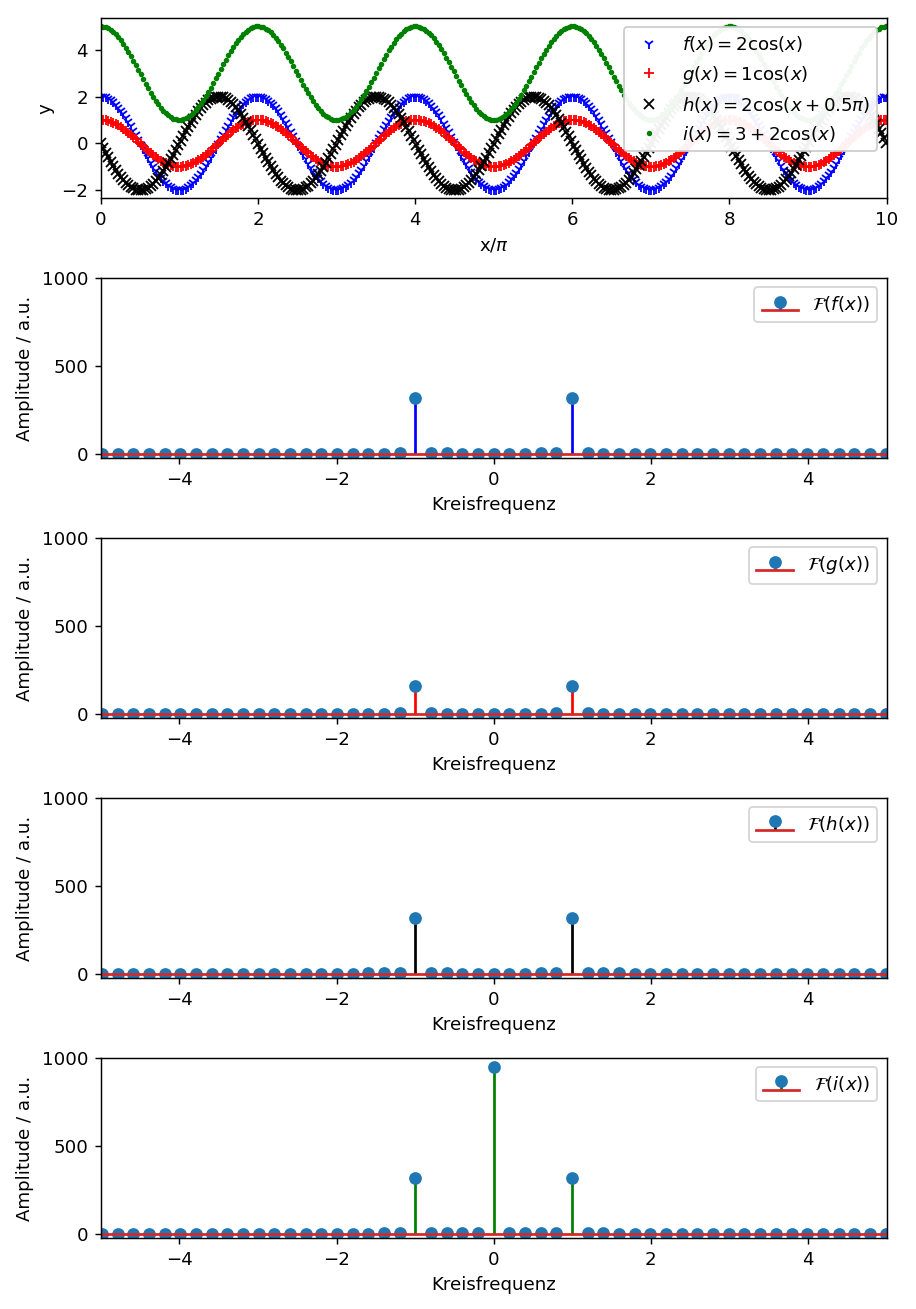

<ipython-input-8-f2eece04d790>:25: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(pad=1)


In [8]:
# Plot the amplitude spektrum
fig = plt.figure(figsize=(7, 10))
plt.subplot(5, 1, 1)
plt.plot(x/np.pi, y_0, 'b1', label=r'$f(x) = 2 \cos(x)$')
plt.plot(x/np.pi, y_0_amplitude, 'r+', label=r'$g(x) = 1 \cos(x)$')
plt.plot(x/np.pi, y_0_phase, 'kx', label=r'$h(x) = 2 \cos(x + 0.5 \pi)$')
plt.plot(x/np.pi, y_0_offset, 'go', ms=2, label=r'$i(x) = 3 + 2 \cos(x)$')
plt.xlabel(r"x/$\pi$")
plt.ylabel("y")
plt.xlim(0, 10)
plt.legend(loc='upper right', framealpha=0.95)

plt.subplot(5, 1, 2)
plot_amplitude(frequencies*2*np.pi, np.abs(A_signal_fft_0), style='b-', label=r'$\mathcal{F}(f(x))$')

plt.subplot(5, 1, 3)
plot_amplitude(frequencies*2*np.pi, np.abs(A_signal_fft_0_amplitude), 'r-', label=r'$\mathcal{F}(g(x))$')

plt.subplot(5, 1, 4)
plot_amplitude(frequencies*2*np.pi, np.abs(A_signal_fft_0_phase), 'k-', label=r'$\mathcal{F}(h(x))$')

plt.subplot(5, 1, 5)
plot_amplitude(frequencies*2*np.pi, np.abs(A_signal_fft_0_offset), 'g-', label=r'$\mathcal{F}(i(x))$')

fig.tight_layout(pad=1)
plt.show()
None

Die wichtigen Punkte sind:
1. Die Amplituden sind spiegelsymmetrisch um $y=0$.
2. Die Skalierung der $y$-Achse entspricht nicht den ursprünglichen Amplituden (vergl. $f(x)$ und $g(x)$).
3. Die halbe Amplitude von $g(x)$ führt aber auch in dieser Darstellung zur halben Amplitude (vergl. $f(x)$, $h(x)$ und $i(x)$).
4. Das Einführen eines konstanten Terms sorgt hier, wie erwartet, für einen Beitrag bei einer Frequenz von 0 (siehe $i(x)$).

Offensichtlich liefert die Fouriertransformation hier redundante (gespiegelte) Informationen. Diese können im vorliegenden Fall einfach abgeschnitten werden, alternativ würde die Nutzung von 
```python
scipy.fft.rfft
```
und 
```python
scipy.fft.rfftfreq
```
diese gar nicht erst berechnen. __Achtung__: Beide Möglichkeiten bestehen nur, da wir reelle Eingabedaten transformieren! Bei komplexen Eingabedaten geht dies nicht.

###### Betrachten wir nun die Phaseninformationen

<IPython.core.display.Javascript object>


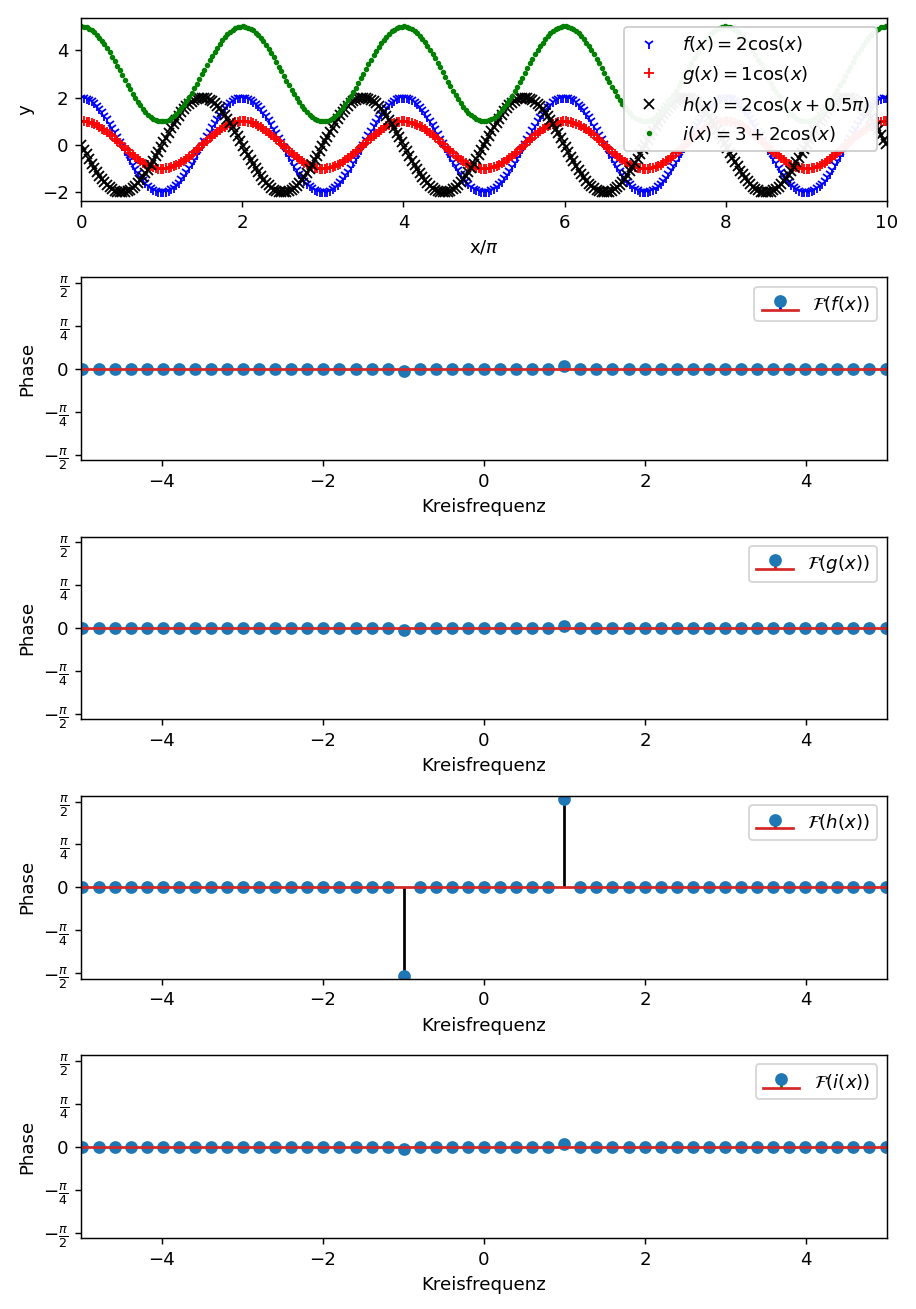

<ipython-input-9-ca299af690c2>:35: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(pad=1)


In [9]:
# Filter small components that arise due to the finite sampling  
A_signal_fft_0_phase[np.abs(A_signal_fft_0_phase) < 10] = 0
A_signal_fft_0_amplitude[np.abs(A_signal_fft_0_amplitude) < 10] = 0
A_signal_fft_0[np.abs(A_signal_fft_0) < 10] = 0
A_signal_fft_0_offset[np.abs(A_signal_fft_0_offset) < 10] = 0

# Plot the phases theta = arctan2(imag, real)
fig = plt.figure(figsize=(7, 10))
plt.subplot(5, 1, 1)
plt.plot(x/np.pi, y_0, 'b1', label=r'$f(x) = 2 \cos(x)$')
plt.plot(x/np.pi, y_0_amplitude, 'r+', label=r'$g(x) = 1 \cos(x)$')
plt.plot(x/np.pi, y_0_phase, 'kx', label=r'$h(x) = 2 \cos(x + 0.5 \pi)$')
plt.plot(x/np.pi, y_0_offset, 'go', ms=2, label=r'$i(x) = 3 + 2 \cos(x)$')
plt.xlabel(r"x/$\pi$")
plt.ylabel("y")
plt.xlim(0, 10)
plt.legend(loc='upper right', framealpha=0.95)

plt.subplot(5, 1, 2)
plot_phase(frequencies*2*np.pi, np.arctan2(A_signal_fft_0.imag, A_signal_fft_0.real), 'b-', 
           label=r'$\mathcal{F}(f(x))$')

plt.subplot(5, 1, 3)
plot_phase(frequencies*2*np.pi, np.arctan2(A_signal_fft_0_amplitude.imag, A_signal_fft_0_amplitude.real), 
         'r-', label=r'$\mathcal{F}(g(x))$')

plt.subplot(5, 1, 4)
plot_phase(frequencies*2*np.pi, np.arctan2(A_signal_fft_0_phase.imag, A_signal_fft_0_phase.real),
         'k-', label=r'$\mathcal{F}(h(x))$')

plt.subplot(5, 1, 5)
plot_phase(frequencies*2*np.pi, np.arctan2(A_signal_fft_0_offset.imag, A_signal_fft_0_offset.real),
         'g-', label=r'$\mathcal{F}(i(x))$')

fig.tight_layout(pad=1)
plt.show()

Auch hier sehen wir was wir erwarten. 
1. Die einzige Funktion mit Phasenverschiebung, $h(x)$, zeigt die gewünschte Phase von $0.5\pi$. 
2. Auch die anderen Funktionen zeigen (nicht signifikante) Phasenausschläge bei der Schwingungsfrequenz. 
3. Die Phaseninformation weißt eine Punktsymmetrie auf. 

Die Ausschläge bei den Funktionen ohne Phase entstehen durch numerische Effekte aufgrund der endlichen Information die durch das begrenzte sampling verfügbar ist. Für die Punktsymmetrie gilt das selbe wie oben, sie können ignoriert werden.

###### Nun ein echtes Beispiel: Sonnenflecken
Wir nutzen das SILSO 13 Month smoothed monthly sunspot dataset https://wwwbis.sidc.be/silso/datafiles.

Spalten des Datensatzes:
* Spalten 1-2: Gregorianisches Datum
 * Jahr
 * Monat
* Spalten 3: Dezimales Datum
* Spalten 4: Geglättete Anzahl an Sonnenflecken pro Monat
* Spalten 5: Standardabweichung der Sonnenfleckenzahl.
* Spalten 6: Anzahl an Einzellobservationen, die zum bestimmen der Sonnenfleckenzahl genutzt wurden.
* Spalten 7: Definitive/provisional Indikator.'1' zeigt, dass die Daten validiert sind. '0' indiziert vorläufige Daten.

In [10]:
# Coloum names
column_names = ['Greg_Year', 'Month', 'Dec_Year', 'N_total_sunspots_smoothed', 
                'Montly_mean_sunspot_number_std', 'N_obs', 'Marker']

# Input
sunspots = pd.read_csv('SN_ms_tot_V2.0.csv', names=column_names, sep=';')
sunspots = sunspots[sunspots['N_total_sunspots_smoothed'] >= 0]
sunspots.head()

,Greg_Year,Month,Dec_Year,N_total_sunspots_smoothed,Montly_mean_sunspot_number_std,N_obs,Marker
6,1749,7,1749.538,135.9,-1.0,-1,1
7,1749,8,1749.623,137.9,-1.0,-1,1
8,1749,9,1749.707,140.2,-1.0,-1,1
9,1749,10,1749.790,143.8,-1.0,-1,1
10,1749,11,1749.874,146.4,-1.0,-1,1


In [11]:
# Inspect data
sunspots.dtypes

Greg_Year                           int64
Month                               int64
Dec_Year                          float64
N_total_sunspots_smoothed         float64
Montly_mean_sunspot_number_std    float64
N_obs                               int64
Marker                              int64
dtype: object

<IPython.core.display.Javascript object>


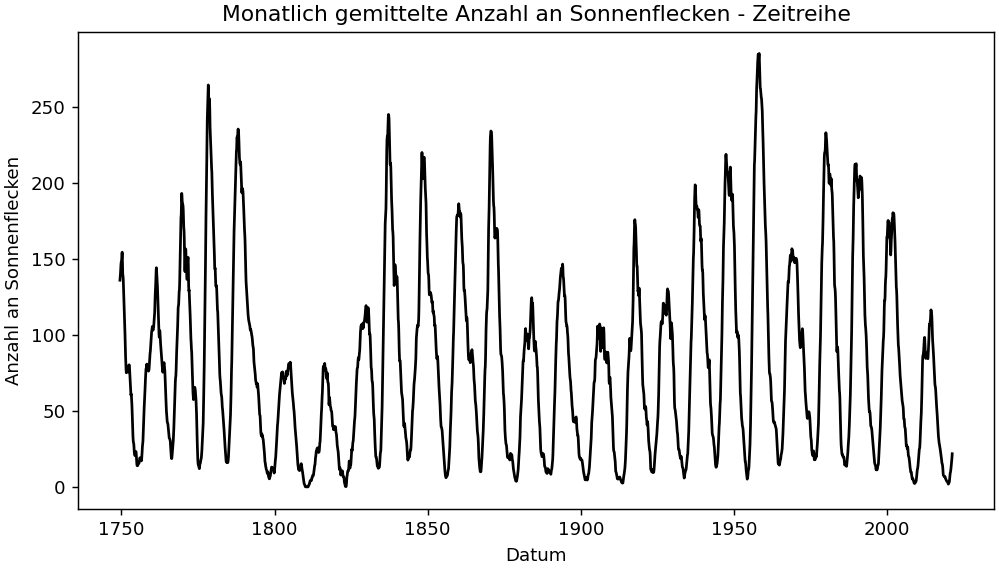

In [12]:
plt.figure(figsize=(7, 4))
plt.plot(sunspots['Dec_Year'], sunspots['N_total_sunspots_smoothed'], 'k-')
plt.xlabel('Datum')
plt.ylabel('Anzahl an Sonnenflecken')
plt.title('Monatlich gemittelte Anzahl an Sonnenflecken - Zeitreihe')
None

Ein grober Blick auf die Daten zeigen bereits interessante Eigenschaften:

1. Es liegt eine Periodizität mit einer Periodendauer ca. 10 Jahren vor.
2. Zwischen 1800 und 1825 gab es ein starkes Minimum in der Sonnenaktivität.
3. Um 1950 gab es ein Maximum der Sonnenaktivität.

Hierzu liegen natürlich Studien vor. Die Periodizität wurde zu 11 Jahren bestimmt (siehe z.B. [diese](https://iopscience.iop.org/article/10.1143/JJAP.33.2821) Veröffentlichung, die einen etwas anderen Ansatz zur Zeitreihenanalyse wählt). Das Minimum zwischen 1800 und 1825, das sogenannte Dalton-Minimum, fällt in die Periode der kleinen Eiszeit. Im Höhepunkt dieser klimatologischen Periode liegt das bekanntere (in den Daten nicht vorhandene) Mounder-Minimum. Die kleine Eiszeit wurde bspw. vom niederländischen Maler Hendrick Avercamp in seinem Gemälde IJsvermaak („Eisvergnügen“) künstlerisch verarbeitet. Es ist jedoch **nicht** davon auszugehen, dass die Minima der solaren Aktivität alleinige Ursache dieser Epoche sind, sie haben sie allenfalls verstärkt.

![Das Gemälde IJsvermaak („Eisvergnügen“) von Hendrick Avercamp](Images/ijsvermaak.jpeg "Das Gemälde IJsvermaak („Eisvergnügen“) von Hendrick Avercamp")

Bei der erhöhten Sonnenaktivität zwischen 1900 und 2000 spricht man vom sogenannten modernen Maximum, es besteht die Möglichkeit, dass dieses aktuell wieder in ein Minimum übergeht und wir uns auf sinkende Temperaturen einstellen müssen.

##### Nun aber zur Analyse der Daten 
Die Daten sind bereits auf einem (annähernd) äquidistanten Grid aufgenomme und liegen in einer Frequenz von 12 Messungen pro Jahr vor. Weiterhin werden die Daten durch reelle Zahlen beschrieben, wir können somit direkt 
```python
scipy.fft.rfft
```
und 
```python
scipy.fft.rfftfreq
```
nutzen.

<IPython.core.display.Javascript object>


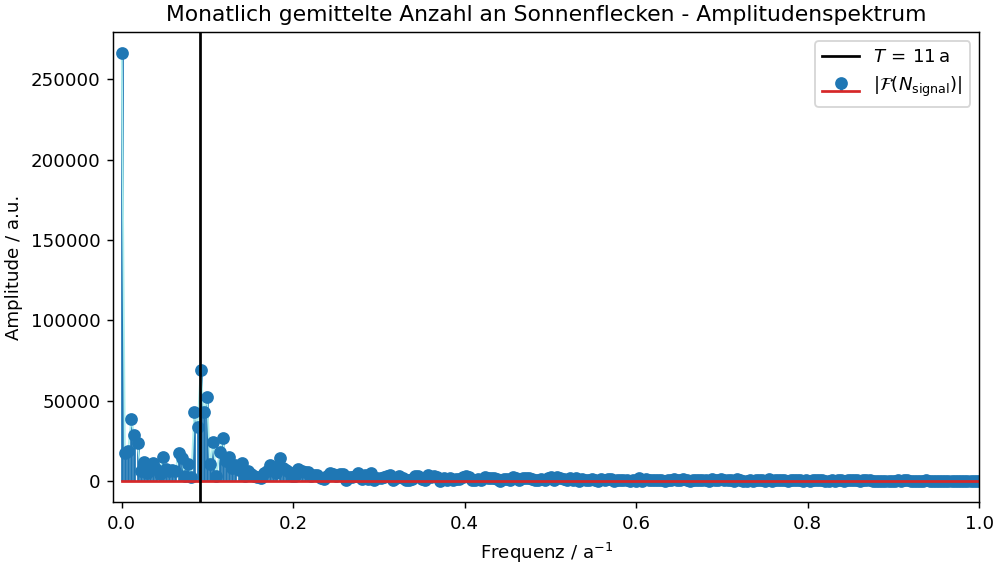

In [13]:
from scipy.fft import rfftfreq, rfft

# Fourier transform
A_signal_fft = rfft(sunspots['N_total_sunspots_smoothed'].to_numpy())
frequencies = rfftfreq(np.size(sunspots['Dec_Year'].to_numpy()), 1/12)

# Plotting
fig=plt.figure(figsize=(7, 4))
plt.clf()
plt.plot(frequencies, np.abs(A_signal_fft), lw=1.0, c='paleturquoise')
plt.stem(frequencies, np.abs(A_signal_fft), label=r"$|\mathcal{F}(N_{\mathrm{signal}})|$")
plt.xlabel(r"Frequenz / a$^{-1}$")
plt.ylabel("Amplitude / a.u.")
plt.xlim(-0.01, 1)
plt.axvline(1/11, 0, 1, label=r'$T\,=\,11\,$a', color='black')
plt.legend(loc='best')
plt.title("Monatlich gemittelte Anzahl an Sonnenflecken - Amplitudenspektrum")
None

Zwei Komponenten stechen besonders hervor:
1. $f = 0$: Der konstante Term der Fourierreihe, der durch den Offset der Daten entlang der $y$-Achse entsteht
2. $f \approx \frac{1}{11} \, \mathrm{a}^{-1}$: Die 11-jährige Periodizität der Sonnenflecken

In der Frequenzdomäne können wir nun auch Filteroperationen durchführen um bspw. die Daten zu glätten. Wir nutzen hier einen Tiefpassfilter, setzen also alle Frequenzanteile oberhalb einer (hier willkürlich) gewählten Grenzfrequenz von $0.2 \, \mathrm{a}^{-1}$ auf 0. In der Realität würden man den Übergang zwischen gefiltertem und durchgelassenen Bereich weit weniger Steil gestalten. Es gibt natürlich weitere Möglichkeiten, z.B. Hochpass- und Bandpassfilter aber auch deutlich fortgeschrittenere Ansätze die selektiver auf den Frequenzraum wirken.

Zur Rücktransformation nutzen wir 
```python
scipy.fft.irfft.
```

<IPython.core.display.Javascript object>


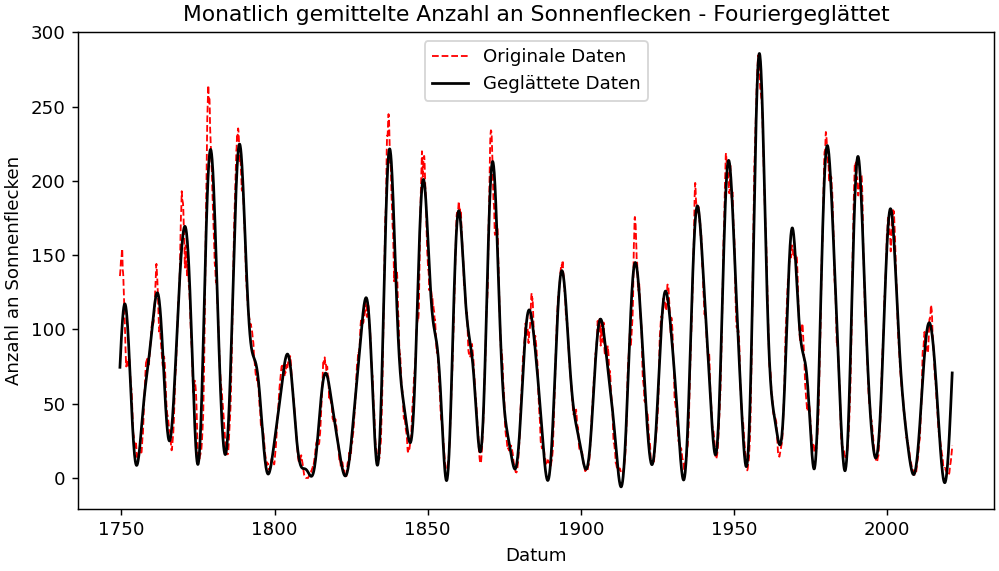

In [14]:
from scipy.fft import irfft

# Copy Amplitudes
A_signal_fft_filtered = A_signal_fft

# Set Amplitudes above 0.2 per year to 0
A_signal_fft_filtered[frequencies>0.2] = 0

# Inverse FFT to re-gain sonspot number per month
A_signal_filtered = irfft(A_signal_fft_filtered, len(sunspots['Dec_Year'].to_numpy()))

# Plot
plt.figure(figsize=(7, 4))
plt.plot(sunspots['Dec_Year'], sunspots['N_total_sunspots_smoothed'], 'r--', lw=1, label='Originale Daten')
plt.plot(sunspots['Dec_Year'], A_signal_filtered, 'k-', label='Geglättete Daten')
plt.xlabel('Datum')
plt.ylabel('Anzahl an Sonnenflecken')
plt.title('Monatlich gemittelte Anzahl an Sonnenflecken - Fouriergeglättet')
plt.legend(loc='best')
None

### Gridding <a name="fourier-grid"></a>

Wie diskutiert ist eine Anforderung an die Durchführbarkeit einer DFT das gleichmäßige Sampling der zu transformierenden Funktion. Was aber tun wenn die Messwerte dies nicht hergeben? Ein solches Problem tritt intrinsisch bspw. auf dem Gebiet der Radioastronomie aber auch der Magnetresonanztomographie (die - mathematisch - eng verwandt sind) auf, aber auch schlicht ungleichmäßig genommene Messwerte erfordern ein entsprechendes Vorgehen. Eine Lösung dieses Problems liegt in der Nutzung sogenannter Gridding-Operationen.

Gridding ist eine sehr problematische aber dennoch notwendige Idee. Grundsätzlich passiert folgendes: Die diskret aber ungleichmäßig mit einer Funktion $S(t)$ gesampelte Funktion $f(t)$ wird in einem ersten Schritt durch Umgewichtung mit $C(t)$ wieder in eine kontinuierliche Funktion überführt, die dann entsprechend eines gleichmäßigen Samplings ausgewertet wird. Dies lässt sich mathematisch formulieren. Ein gleichmäßiges Sampling kann durch einen sogenannten Dirac-Kamm 

$$
\begin{equation}
    III_{\rm \Delta}(t) = \sum_{n \in \mathbf{Z}}^{}  \delta{t + n\rm \Delta}
\end{equation}
$$

beschrieben werden. Die zeitliche Begrenzung der Messung kann durch die Boxcar-Funktion $\Pi$ 

$$
\begin{equation}
    \begin{split}
        \Pi_{t_0,t_1}(t)
                       =\,\left \{
                       \begin{array}{lll}
                        0 & {\rm für} & x < t_0 \\
                        1 & {\rm für} & t_0 \le t \le t_1 \\
                        0 & {\rm für} & t > t_1 \\
                       \end{array} \right. \end{split}
\end{equation}
$$

dargestellt werden.

Mit diesen Definitionen folgt für die Messwerte nach Gridding

$$
\begin{equation}
    \hat{f}(t) = [[f(t) S(t)] * C(t)]III_{\rm \Delta}(t)\Pi_{t_0,t_1}(t),
\end{equation}
$$

wobei $g*h$ eine Faltung beschreibt.

Es handelt sich hierbei um eine kontinuierliche Funktion. Bei Nutzung der CDF verwandeln $III(t)$ und $\Pi(t)$ das Integral aber gerade so in eine Summe, dass wir wieder bei der Definition der DFT ankommen, es wird schlussendlich also die DFT einer Faltung zweier Funktionen berechnet. Entsprechend des Faltungstheorems erhalten wir als Ergebnis die Multiplikation aus den gesuchten, fouriertransformierten Werten der Ausgangsfunktion multipliziert mit den ungewünschten fouriertransformierten Werten der Gewichtungsfunktion. Auch wenn es Strategien gibt mit diesem Problem umzugehen, Gridding sollte vermieden werden wo immer es sich vermeiden lässt.

###### Dazu ein Beispiel

Bestimmen wir $C(t)$ so, dass eine lineare Interpolation zwischen den nächsten Nachbarn der ungleichmäßig gesampelten Daten durchgeführt wird. Das ungleichmäßige Sampling sei durch zufällige Messzeitpunkte modelliert. Die gemessene Funktion sei

$$
\begin{equation}
    f(x) = \sin{\left(x + \frac{\pi}{2} \right)}.
\end{equation}
$$

In [15]:
from scipy.stats import uniform
from scipy.interpolate import interp1d

# Original Sampling points
np.random.seed(1337)
sampling_points = np.sort(np.append(uniform(0, 10*np.pi).rvs(size=58), [0, 10*np.pi]))
sampled_function = np.sin(sampling_points + np.pi/2)

# Resampling function
def resampled_fuction(x, x_orig, y_orig):
    interp = interp1d(x_orig, y_orig)
    return interp(x)

# New equidistant sampling points
gridded_x = np.linspace(0.1, 9.9*np.pi, 60)
gridded_y = resampled_fuction(gridded_x, sampling_points, sampled_function)

# Data that is sampled equidistant from the beginning
equidistant_y = np.sin(gridded_x + np.pi/2)

# FFT
A_signal_gridded = rfft(gridded_y)
A_signal_equidistant = rfft(equidistant_y)
frequencies = rfftfreq(np.size(gridded_x), np.diff(gridded_x)[0])

<IPython.core.display.Javascript object>


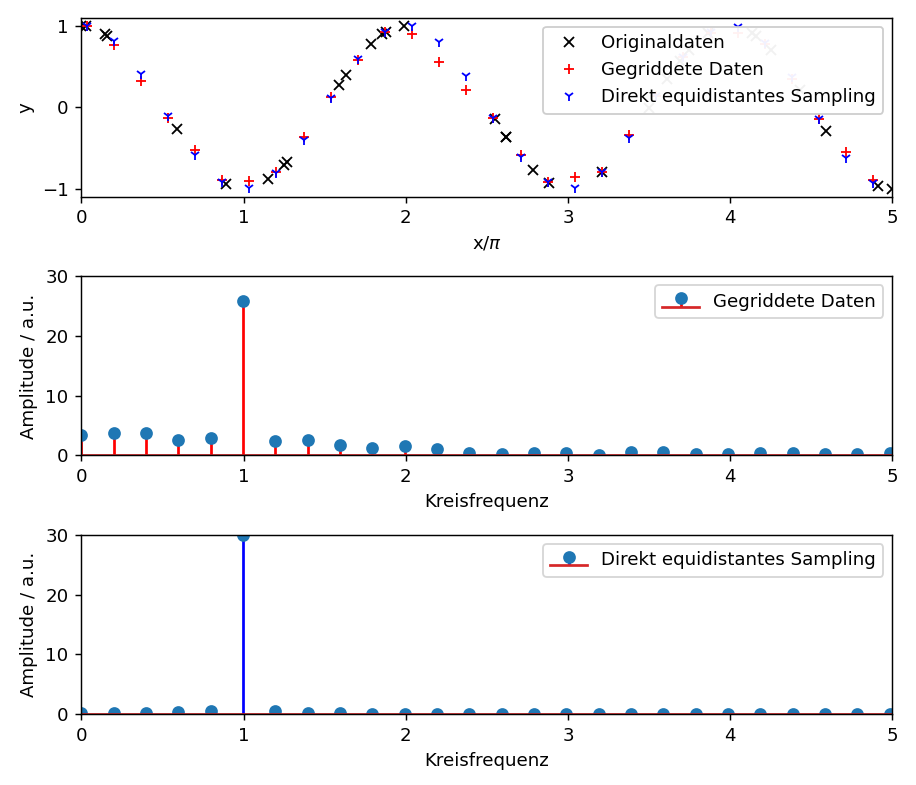

<ipython-input-16-a8d78b50641e>:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(pad=1)


In [16]:
# Plotting
fig = plt.figure(figsize=(7, 6))
plt.subplot(3, 1, 1)
plt.plot(sampling_points/np.pi, sampled_function, 'kx', label='Originaldaten')
plt.plot(gridded_x/np.pi, gridded_y, 'r+', label='Gegriddete Daten')
plt.plot(gridded_x/np.pi, equidistant_y, 'b1', label='Direkt equidistantes Sampling')
plt.xlabel(r"x/$\pi$")
plt.ylabel("y")
plt.xlim(0, 5)
plt.legend(loc='upper right', framealpha=0.95)

plt.subplot(3, 1, 2)
plot_amplitude(frequencies*2*np.pi, np.abs(A_signal_gridded), 'r-', 
               label='Gegriddete Daten', xlim=(0, 5), ylim=(0, 30))

plt.subplot(3, 1, 3)
plot_amplitude(frequencies*2*np.pi, np.abs(A_signal_equidistant), 'b-', 
         label='Direkt equidistantes Sampling', xlim=(0, 5), ylim=(0, 30))
fig.tight_layout(pad=1)

Durch das Gridding erhalten wir in diesem Fall Frequenzanteile die in den Daten nicht vorhanden sind und nicht vorhanden wären, hätten wir die Daten äquidistant gemessen. Das eigentlich korrekte Fourierspektrum wird ausgeschmiert.

### FFT <a name="fourier-fft"></a>

>The FFT is one of the truly great computational developments of
>this [20th] century. It has changed the face of science and
>engineering so much that it is not an exaggeration to say that life
>as we know it would be very different without the FFT.  
>*Charles van Loan, Computational Frameworks of the FFT, 1992*

>The Fast Fourier Transform—the most valuable numerical algorithm in our lifetime.  
*Gil Strang, Introduction to Linear Algebra, 2003*

>FFT voted one of the top 10 algorithms of the 20th century.  
*IEEE Computing in Science & Engineering, 1-2/2000*

Die oben eingeführte DFT ist mit einer Laufzeit $\mathcal{O}(N^2)$ äußerst laufzeitintensiv, der zuerst 1964 von Cooley und Tukey in ihrem Paper __An Algorithm for the Machine Calculation of Complex Fourier Series, Math. Comput. 19: 297-301__ eingeführte *Fast Fourier Transformation (FFT)* Algorithmus erlaubt die Berechnung in einer Zeit $\mathcal{O}(N \log_{2}{(N)})$.

Zur Implementierung wird die DFT in zwei Summen je über die geraden und die ungeraden Indizes aufgespalten

$$
\begin{aligned}
    \tilde{f}_{\text{diskret}}(\omega_{n}) = 
    \sum_{k=0}^{N-1} f_{\text{diskret}}(t_k) \exp{\left(2\pi\mathrm{i} \frac{kn}{N}\right)} &= 
    \sum_{k=0}^{\frac{N}{2}-1} f_{\text{diskret}}(t_{2k}) \exp{\left(2\pi\mathrm{i} \frac{2kn}{N}\right)} +
    \sum_{k=0}^{\frac{N}{2}-1} f_{\text{diskret}}(t_{2k+1}) \exp{\left(2\pi\mathrm{i} \frac{(2k+1)n}{N}\right)}\\ &=
    \sum_{k=0}^{\frac{N}{2}-1} f_{\text{diskret}}(t_{2k}) \exp{\left(2\pi\mathrm{i} \frac{kn}{N/2}\right)} +
    \exp{\left(\frac{2\pi\mathrm{i}n}{N}\right)} \sum_{k=0}^{\frac{N}{2}-1} f_{\text{diskret}}(t_{2k+1}) \exp{\left(2\pi\mathrm{i} \frac{kn}{N/2}\right)}\\ &=
    \tilde{f}\,_{\text{diskret}}^{\text{gerade}}(\omega_{n}) + W^{n} \cdot \tilde{f}\,_{\text{diskret}}^{\text{ungerade}}(\omega_{n})
\end{aligned}
$$

Der gerade und ungerade Anteil von $\tilde{f}_{\text{diskret}}(\omega_{n})$ können je in $\left( \frac{N}{2} \right)^{2}$, die $W^{n}$ in $N$ Operationen berechnet werden. In Summe werden also noch $2\left( \frac{N}{2} \right)^{2} + N$ Operationen benötigt. Ist nun $N=2^{m}$ kann diese Aufteilung $m-1$ mal iterativ wiederholt werden, die Laufzeit sinkt auf $\mathcal{O}(N \log_{2}{(N)})$. Dies führt z.B. bei $N = 2^4 = 16$ zu einem Unterschied von 256 (DFT) zu 64 (FFT) Operationen, die FFT braucht hier also ein Viertel der Laufzeit einer DFT.

Das vorgestellte Vorgehen ist ein sogenanntes *divide and conquer*-Verfahren (Diese Verfahren haben immer eine logarithmische Laufzeitabhängigkeit). Der offensichtliche Nachteil dieser Implemetation liegt darin, dass $N$ nun eine Potenz von 2 sein muss. Dennoch ist der Laufzeitunterschied dermaßen enorm, dass FFT-Algorithmen fast ausschließlich genutzt und die Daten notfalls aufgefüllt werden bis diese Vorraussetzung erfüllt ist.

Es existieren weitere Ansätze bzw. Alternativen zur Formulierung einer FFT, unter anderem durch die Aufteilung in mehr als 2 Summen (bspw. Radix-4 und Radix-8), gänzlich unterschiedliche Aufteilungen (Winograd-Algorithmus) oder durch Umformulierung der DFT als Faltung (z.B. der Bluestein Algorithmus).

<IPython.core.display.Javascript object>


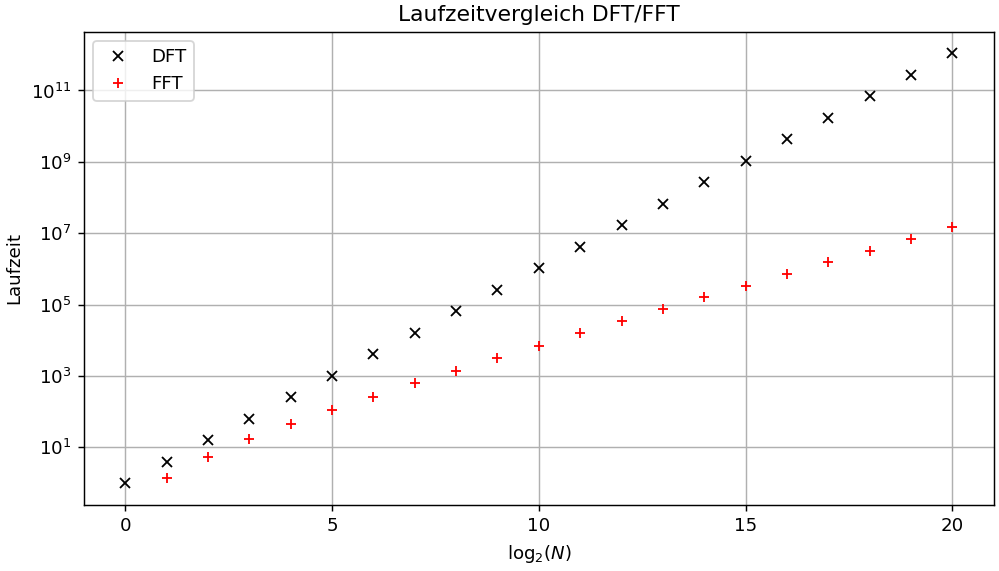

In [17]:
m = np.arange(0, 21, 1)
N = 2**m

plt.figure(figsize=(7, 4))
plt.clf()
plt.yscale('log')
plt.plot(m, N**2, 'kx', label='DFT')
plt.plot(m, N*np.log(N), 'r+', label='FFT')
plt.xticks([0, 5, 10, 15, 20], ["0", "5", "10", "15", "20"])

plt.xlabel(r'log$_{2}(N)$')
plt.ylabel('Laufzeit')
plt.grid()
plt.title("Laufzeitvergleich DFT/FFT")
plt.legend(loc='best')
None

## Lomb-Scargle Periodogramme <a name="period"></a>

### Mathematische Grundlagen <a name="period-mat"></a>

Die folgenden Ausführungen stammen im Wesentlichen aus: **J.D. Scargle “Studies in astronomical time series analysis. II - Statistical aspects of spectral analysis of unevenly spaced data”, The Astrophysical Journal, vol 263, pp. 835-853, 1982.**

Die einfachste Version eines Periodograms ist definiert als

\begin{equation}
    P_X(\omega) = \frac{1}{N_0} \left|\mathrm{FT}_X(\omega) \right|^2 \quad \text{mit} \ \mathrm{FT}_X(\omega) = \sum_{j=1}^{N_0} X(t_j) \exp(-i \omega t_j) \, .
\end{equation}

Einsetzen und Ausnutzen der Euler-Relation führt zu

\begin{align}
P_X(\omega) &= \frac{1}{N_0} \left| \sum_{j=1}^{N_0} X(t_j) \exp(-i \omega t_j) \right|^2 \\
&= \frac{1}{N_0} \left[ \left(\sum_j X_j \cos(\omega t_j) \right)^2 + \left(\sum_j X_j \sin(\omega t_j) \right)^2 \right] \, .
\end{align}

Für äquidistante Sampling Zeiten mit einem Intervall von $\mathrm{\Delta}t$ folgt

\begin{equation}
    P_X(\omega) = \frac{1}{N_0} \left|\sum^{N_0}_{j=1} X_j \exp(-ij\omega) \right|^2 \, ,
\end{equation}

wenn $\mathrm{\Delta t} = 1$, $t_j = j$ und $X_j = X(t_j)$ gewählt wird. Obige Formel kann mit den Frequenzen $\omega_n = 2 \pi n/T \quad(n = -N_0/2, ..., +N_0/2)$ sehr schnell mittels der Fast-Fourier Transformation (FFT) ausgewertet werden.

Aufgrund zweier Probleme (statistische Schwierigkeiten mit Noise und "spectral leakage"), hat Jeffrey D. Scargle 1982 eine verbesserte Version des Periodogramms entwickelt:

\begin{equation}
     P_X(\omega) = \frac{1}{2} \left \{\frac{\left[\sum_{j}X_j \cos(\omega(t_j - \tau) \right]^2}{\sum^N_{j=1} \cos^2(\omega(t_j - \tau))} + \frac{\left[\sum_{j}X_j \sin(\omega(t_j - \tau) \right]^2}{\sum^N_{j=1} \sin^2(\omega(t_j - \tau))} \right \} \, ,
\end{equation}

wobei $\tau$ definiert ist als

\begin{equation}
    \tan(2 \omega \tau) = \frac{\sum_j \sin(2 \omega t_j)}{\sum_j \cos(2 \omega t_j)} \, .
\end{equation}

Das Lomb-Scargle Periodogram für $m$ Frequenzen ist identisch zu den $m$ goodness-of-fit Statistiken die konstruiert werden können, wenn $m$ sinusodiale Funktionen (mit $m$ Frequenzen) per Kleinste-Quadrate an die Messwerte gefittet werden.

### Beispiele <a name="period-bsp"></a>

##### Zuerst wieder ein einfaches Beispiel: Sinusoidale Funktionen

Um die Feinheiten des Periodogrammes darzustellen nutzen wir hier 3 eng verwandte Funktionen:

$$
\begin{aligned}
f(x) &= 2 \cos{(x)} \\
g(x) &= 2 \cos{(x + 0.5 \pi)} \\
h(x) &= 2 \cos{(x)} + 3 \\
\end{aligned}
$$

Die Periodogramme werden durch
```python
scipy.signal.lombscargle
```
berechnet. Zu beachten ist, dass das Periodogram auf Kreisfrequenzen arbeitet.

In [18]:
from scipy.signal import lombscargle

# Define some constants
A = 2.0
w = 1.0
phi = 0.5 * np.pi
n_in = 1000
n_frequencies = 100000
frac_points = 0.25  # 1-Fraction of points to select as "measured"

# Get the x-positions
rng = np.random.default_rng()
r = rng.uniform(size=n_in)
x = np.linspace(0.01, 10*np.pi, n_in)
x = x[r < frac_points] # Randomly select measured points by rejection

# Get the frequencies for which the periodogram should be evaluated
f = np.linspace(0.01, 10, n_frequencies)

# Get y-values
y_0 = A * np.cos(w*x) # centered around 0
y_0_phase = A * np.cos(w*x+phi) # centered around 0 but with different phase
y_0_offset = y_0 + 3 # offset of 3

# Compute Periodograms
pgram_0 = lombscargle(x, y_0, f, normalize=True) # Periodogram for A cos(x+0.5)
pgram_0_phase = lombscargle(x, y_0_phase, f, normalize=True) # Periodogram for A cos(x+0.25)
pgram_offset = lombscargle(x, y_0_offset, f, normalize=True) # Periodogram for A cos(x+0.5) + 3
pgram_corr = lombscargle(x, y_0_offset-np.mean(y_0_offset), f, normalize=True) 
# Periodogram for A sin(x+0.5) + 3 - E(A sin(x+0.5) + 3)

<IPython.core.display.Javascript object>


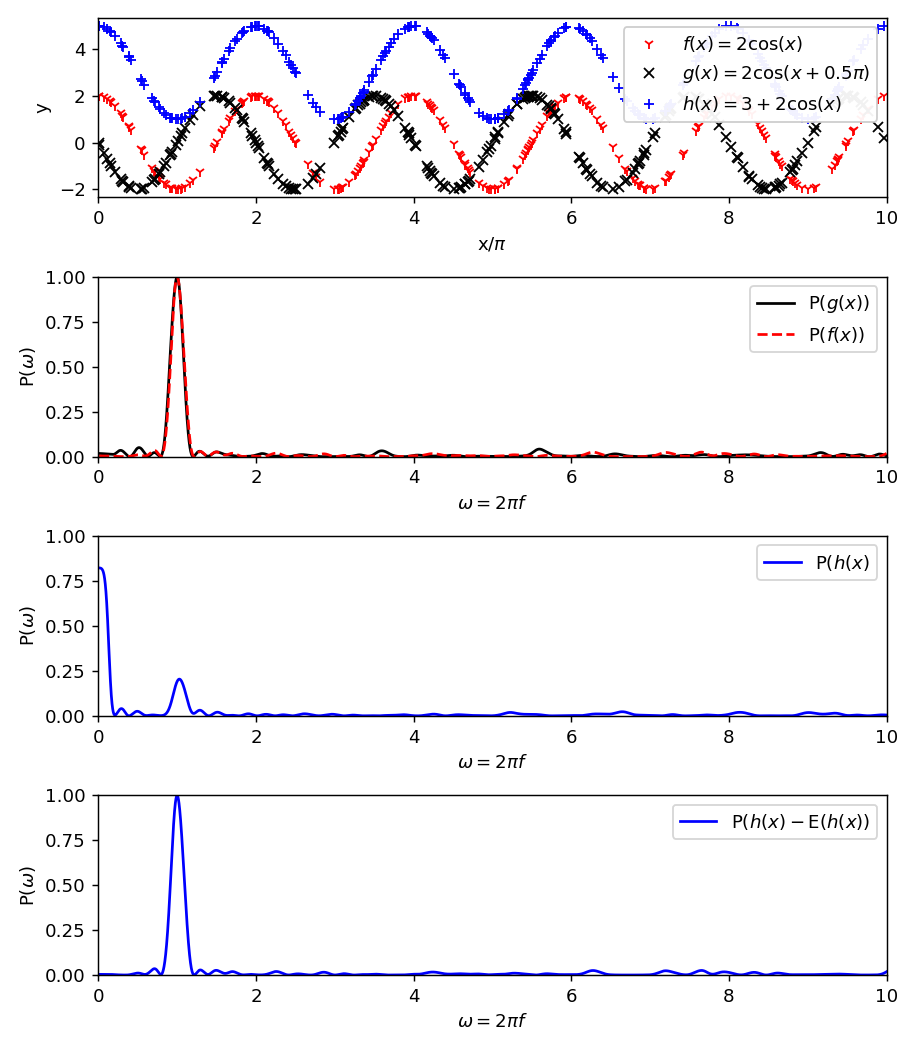

<ipython-input-19-75af93ac3b00>:36: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(pad=1)


In [19]:
# Plotting
fig = plt.figure(figsize=(7, 8))
plt.subplot(4, 1, 1)
plt.plot(x/np.pi, y_0, 'r1', label=r'$f(x) = 2 \cos(x)$')
plt.plot(x/np.pi, y_0_phase, 'kx', label=r'$g(x) = 2 \cos(x + 0.5 \pi)$')
plt.plot(x/np.pi, y_0_offset, 'b+', label=r'$h(x) = 3 + 2 \cos(x)$')
plt.xlabel(r"x/$\pi$")
plt.ylabel("y")
plt.xlim(0, 10)
plt.legend(loc='upper right', framealpha=0.95)

plt.subplot(4, 1, 2)
plt.plot(f, pgram_0_phase, 'k', label=r'$\mathrm{P}(g(x))$')
plt.plot(f, pgram_0, 'r--', label=r'$\mathrm{P}(f(x))$')
plt.xlabel(r"$\omega = 2 \pi f$")
plt.ylabel(r"$\mathrm{P}(\omega)$")
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.legend(loc='upper right')

plt.subplot(4, 1, 3)
plt.plot(f, pgram_offset, 'b-', label=r'$\mathrm{P}(h(x)$')
plt.xlabel(r"$\omega = 2 \pi f$")
plt.ylabel(r"$\mathrm{P}(\omega)$")
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.legend(loc='upper right')

plt.subplot(4, 1, 4)
plt.plot(f, pgram_corr, 'b-', label=r'$\mathrm{P}(h(x) - \mathrm{E}(h(x))$')
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.xlabel(r"$\omega = 2 \pi f$")
plt.ylabel(r"$\mathrm{P}(\omega)$")
plt.legend(loc='upper right')
fig.tight_layout(pad=1)
plt.show()

Wir sehen 4 Dinge:
1. Es ist unerheblich, dass die Datenpunkte nicht äquidistant liegen.
2. Phaseninformationen gehen verloren (vergleiche $f(x)$ und $g(x)$, 2. Grafik von oben).
3. Verschobene Daten erzeugen wie bei der Fourieranalyse einen Peak um 0 (siehe $h(x)$, 3. Grafik von oben).
4. Korrektur um den Mittelwert kann (ausreichend Daten vorrausgesetzt) um diesen Offset korrigieren (siehe $h(x)$, unterste Grafik).

##### Nun wieder zu den Sonnenflecken

<IPython.core.display.Javascript object>


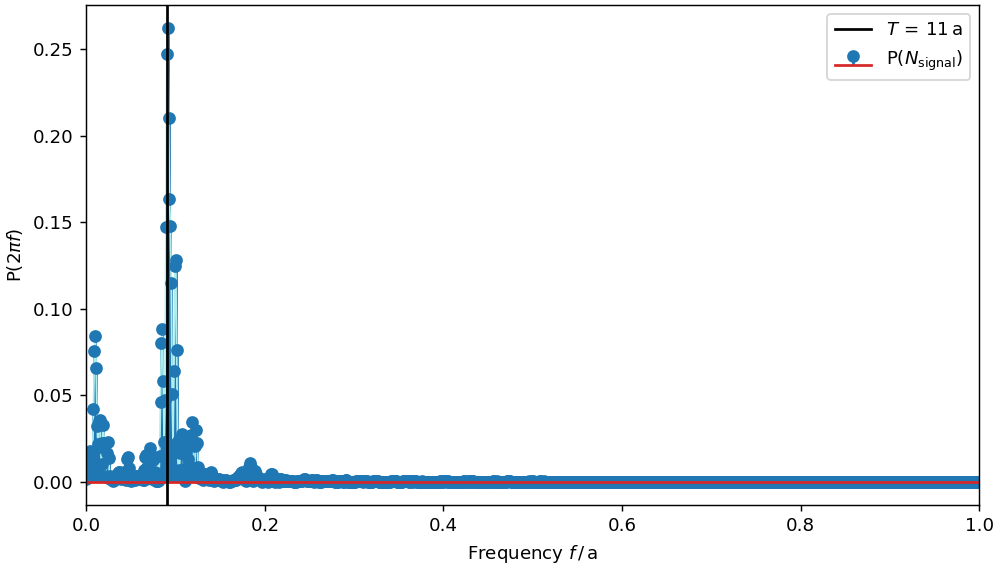

In [20]:
freq = np.linspace(0.001, 2*np.pi, 1000) # frequencies, at which the periodogram should be computed. Please note
# that the periodogram uses angular frequencies instead of normal frequencies
pgram = lombscargle(sunspots['Dec_Year']-sunspots['Dec_Year'].iloc[0], 
                    sunspots['N_total_sunspots_smoothed']-np.mean(sunspots['N_total_sunspots_smoothed']), 
                    freq, normalize=True) # Compute the periodogram correcting for the offset of the data

plt.figure(figsize=(7, 4))
plt.plot(freq/(2*np.pi), pgram, lw=1.0, c='paleturquoise')
plt.stem(freq/(2*np.pi), pgram, label=r"$\mathrm{P}(N_{\mathrm{signal}})$")
plt.axvline(1/11, 0, 1, label=r'$T\,=\,11\,$a', color='black')
plt.xlabel(r'Frequency $f\,/\,\mathrm{a}$')
plt.ylabel(r"$\mathrm{P}(2\pi f)$")
plt.legend(loc='best')
plt.xlim(0, 1)
None

Es zeigt sich ein ähnliches Bild wie bei der Fourieranalyse, ein deutlicher Peak bei $f \approx \frac{1}{11} \, \mathrm{a}^{-1}$ ist sichtbar. Auch hier ist wieder darauf zu achten, dass das Periodogram auf Kreisfrequenzen arbeitet und daher ein Faktor $2\pi$ beachtet werden muss.

## Fourier vs. Lomb-Scargle <a name="vergl"></a>

**Fourier Transformation**:
- gibt Amplitude und Phase zurück
- benötigt äquidistantes Sampling
- numerisch sehr effiziente Implementierungen
- kann invertiert werden

**Lomb-Scargle Periodogramm**:
- gibt nur Amplituden Informationen
- keine Sampling Beschränkungen
- höhere Frequenz-Auflösung bei einer gegebenen Anzahl an Sampling Punkten
- ideal für den Nachweis einer Frequenz Komponente

Es existieren weitere Vor- und Nachteile, die hier nicht diskutiert wurden.

## Ausblick und weitere Literatur <a name="ausblick"></a>

Diese Vorlesung konnte nur einen äußerst begrenzten Einblick in zwei Methoden der Zeitreihenanalyse bieten. Damit sind weder Fourieranalysen und Lomb-Scargle Periodogramme abschließend besprochen noch die Möglichkeiten der Zeitreihenanalyse vollständig ausgeschöpft. Tiefere Einblicke in beide Methoden (und natürlich mehr) werden in der Vorlesung [__SMD II__](https://www.lsf.tu-dortmund.de/qisserver/rds?state=verpublish&status=init&vmfile=no&publishid=228690&moduleCall=webInfo&publishConfFile=webInfo&publishSubDir=veranstaltung), einem einwöchigen Blockkurs im SS mit 3CP, geboten. Hier wird bspw. diskutiert, wie die Signifikanz eines Signales in einem Fourierspektrum oder Lomb-Scargle Periodogram abgeschätzt werden kann.

Eine weitere anwendungsnahe Veranstaltung, die Techniken aus dem Bereich der Fourieranalysen aber auch weitere in SMD behandelte Analysemethoden nutzt, ist die Vorlesung [Digitale Bildverarbeitung](https://graphics.cs.tu-dortmund.de/lehre/lehrveranstaltungen/ws-2020/2021/digitale-bildverarbeitung) des Lehrstuhls 7 (Computergraphik) der Fakultät für Informatik. Diese Vorlesung kann auch zur Vorlesung [Medizinische Bildverarbeitung](https://graphics.cs.tu-dortmund.de/lehre/lehrveranstaltungen/ws-2020/2021/medizinische-bildverarbeitung) ergänzt werden. Letztere "Ausprägung" ist für einige der Schwerpunkte im Master Medizinphysik verpflichtend, beide Vorlesungen eigenen sich aber auch sehr gut für interessierte Studierende der Physik die sich in Analysemethoden von Bildern fortbilden möchten.

Da die Radioastronomie untrennbar mit der Fouriertransformation verknüpft ist, existiert auf diesem Gebiet eine umfangreiche Literatur. Besonders erwähnt seien die Vorlesungsunterlagen zur Mastervorlesung __Fundamentals of Radio Interferometry__ des Rhodes Centre for Radio Astronomy Techniques & Technologies. Es handelt sich dabei um eine Sammlung von jupyter notebooks, die bei [Github](https://github.com/ratt-ru/fundamentals_of_interferometry) zu finden sind und denen Teile dieser Vorlesung entnommen sind. Passend zu dieser Vorlesung ist das [Kapitel 2](https://github.com/ratt-ru/fundamentals_of_interferometry/tree/master/2_Mathematical_Groundwork), [Kapitel 5](https://github.com/ratt-ru/fundamentals_of_interferometry/tree/master/5_Imaging) behandelt u.A. Probleme und Strategien des Griddings. 

Weitere Ausführungen sowohl zum Lomb-Scargle Periodogram als auch zur Fourieranalyse finden sich im lesenswerten Review __Understanding the Lomb-Scargle Periodogram__ von Jacob T. VanderPlas, zu finden auf [arxiv](https://arxiv.org/pdf/1703.09824.pdf).

Weiterhin lassen sich unter dem Stichwort __Zeitreihenanalyse__ (Time Series Analysis) viele weitere Informationsquellen finden. 